In [1]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logging.getLogger("dowhy").setLevel(logging.INFO)

# 1.数据预处理

In [2]:
hotel_bookings=pd.read_csv("hotel_bookings.csv")
hotel_bookings.isnull().sum() 

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [3]:
data=hotel_bookings.copy()
#由于company以及agent两个字段缺失值较多，所以直接删除这两个字段;对于country这个字段，用出现频率最高的国家填补缺失值
data = data.drop(['agent','company'],axis=1)
data['country']= data['country'].fillna(data['country'].mode()[0])

In [4]:
#计算累计天数
data['total_stay'] = data['stays_in_week_nights']+data['stays_in_weekend_nights']

#计算同行人数
data['guests'] = data['adults']+data['children'] +data['babies']

#按照预定房源与分配房源是否相同，给数据集打上标签
data['different_room_assigned']=0
slice_indices =data['reserved_room_type']!=data['assigned_room_type']
data.loc[slice_indices,'different_room_assigned']=1
data = data.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                 ,'reserved_room_type','assigned_room_type','reservation_status','reservation_status_date'
                  ,'arrival_date_day_of_month','arrival_date_year'],axis=1)

Text(0.5, 1.0, 'The Distribution of Users')

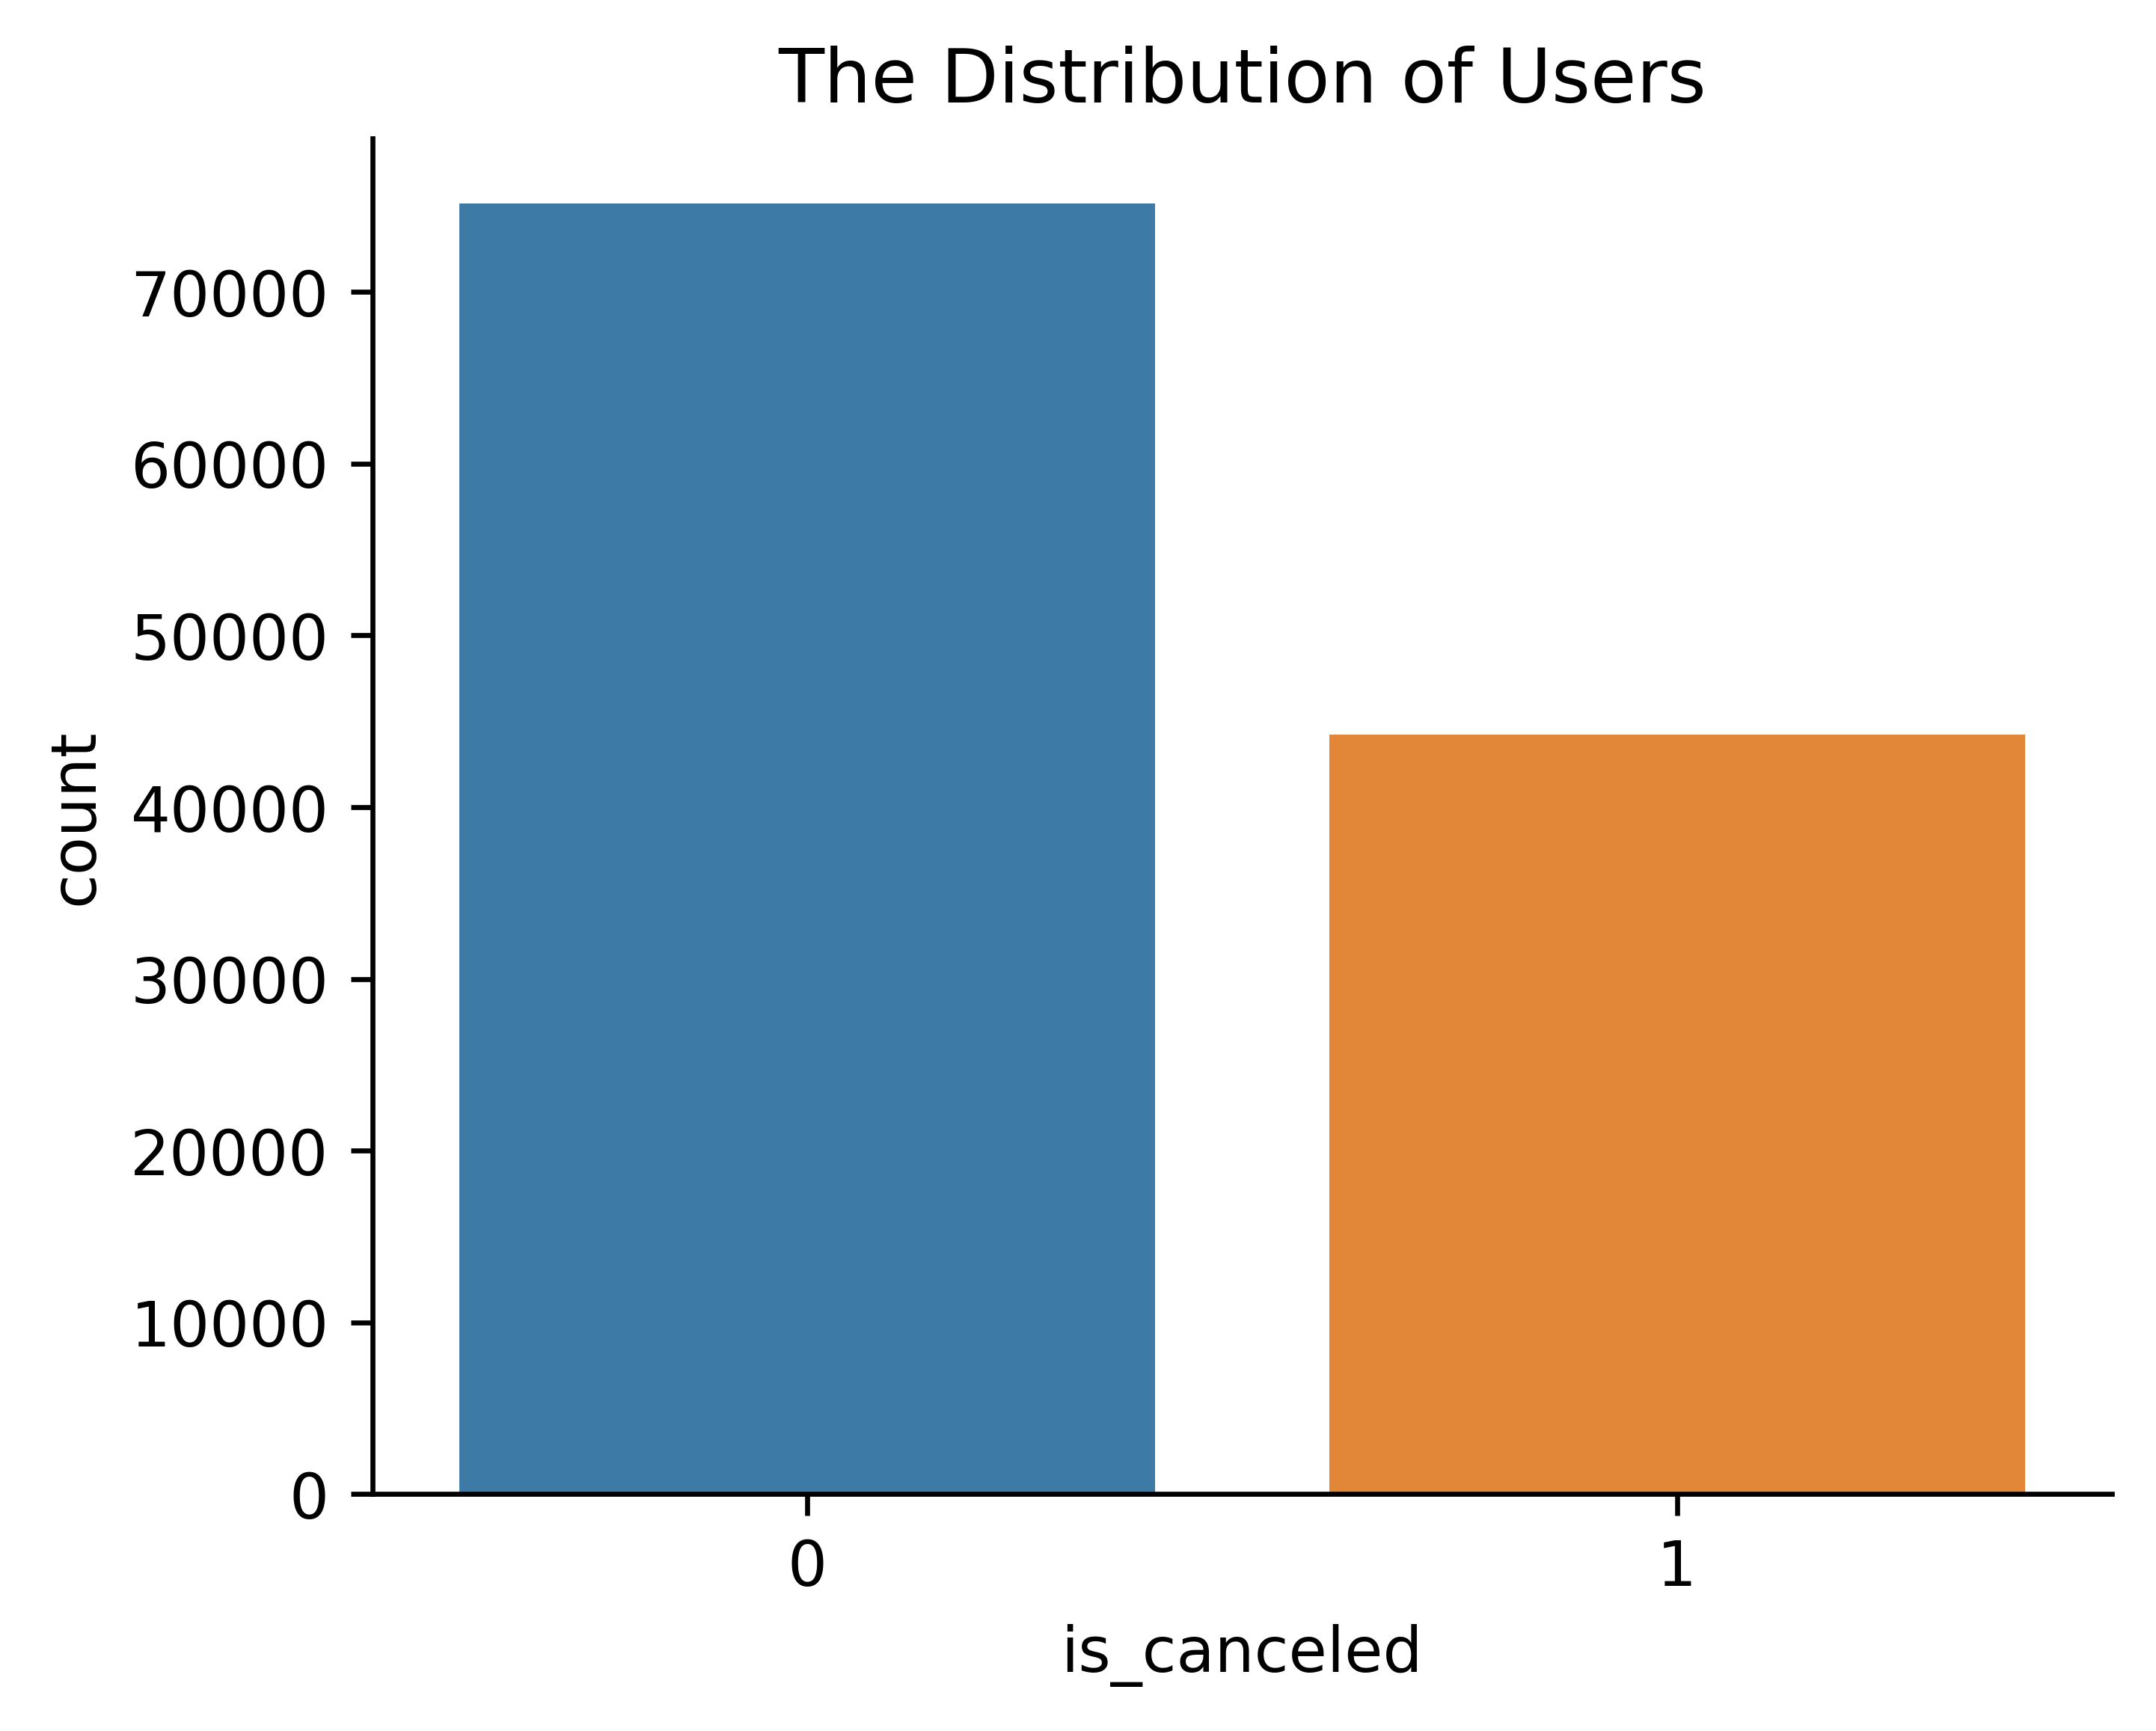

In [51]:
fig,axes= plt.subplots(figsize=(5,4),dpi=600)

ax1=sns.countplot(x=data['is_canceled'],alpha=.95)
sns.despine()
plt.title('The Distribution of Users')


Text(0.5, 1.0, 'The Distribution of Users')

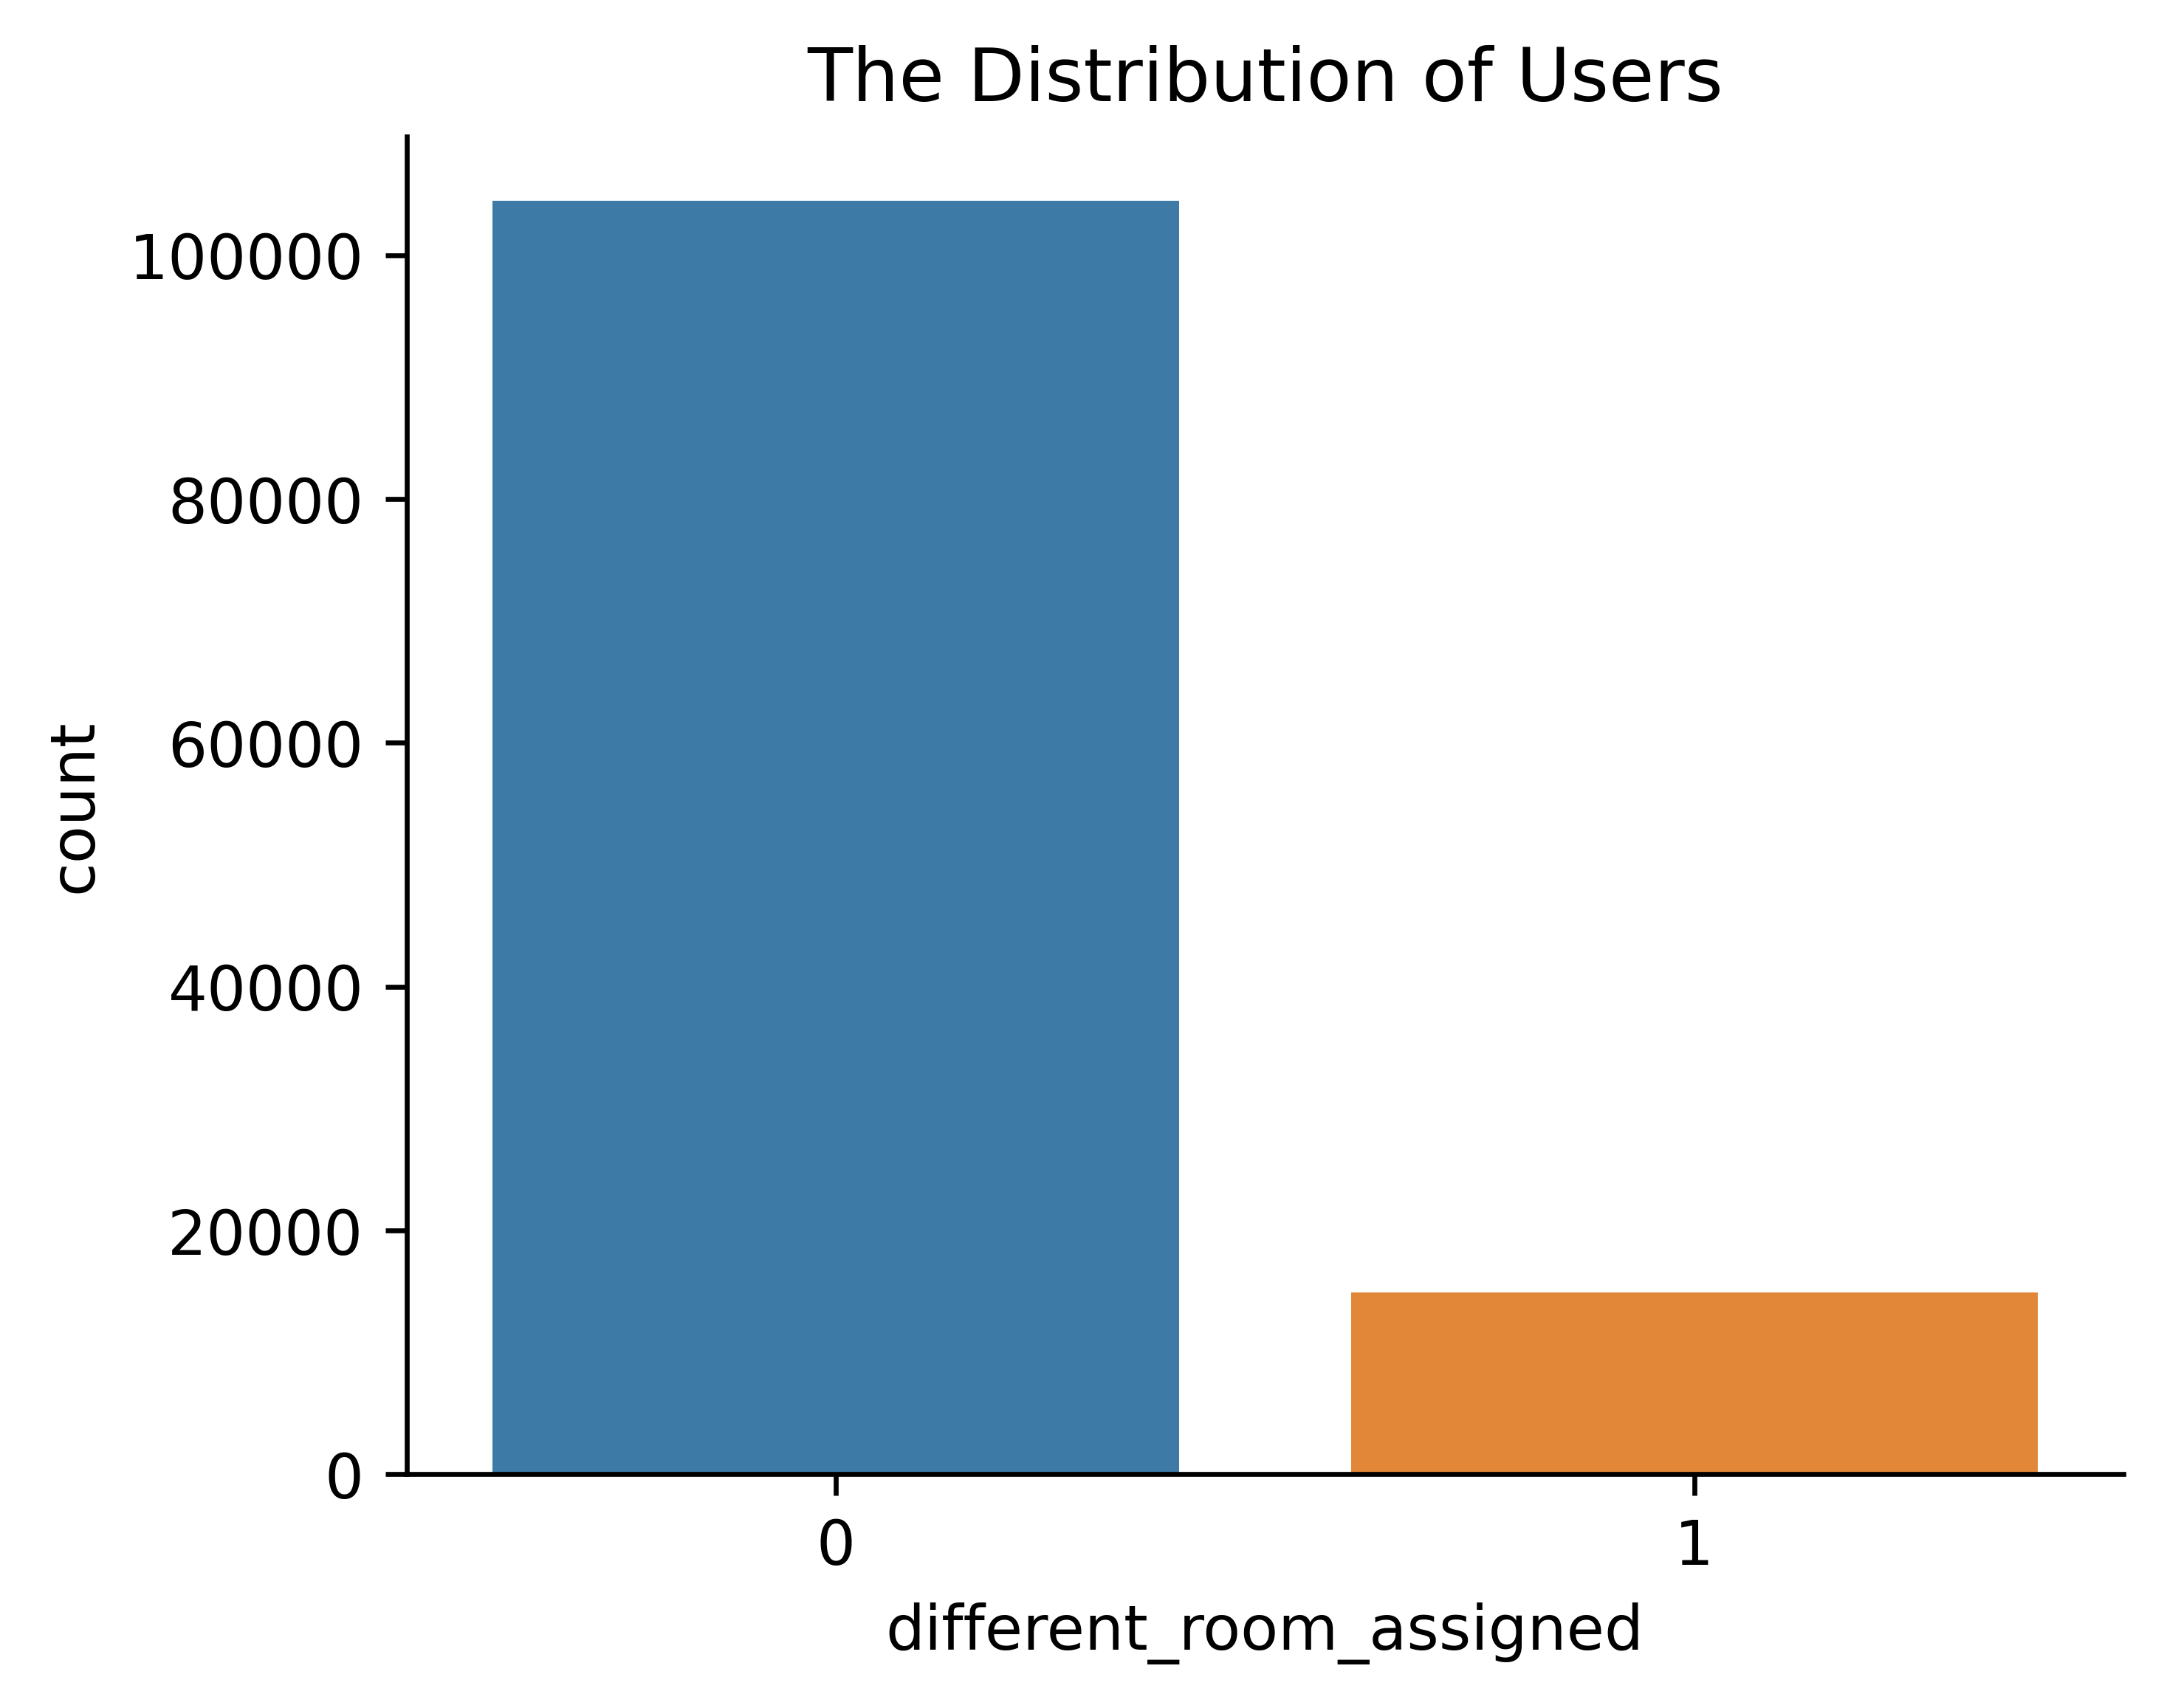

In [52]:
fig,axes = plt.subplots(figsize=(5,4),dpi=600)
sns.countplot(x=data['different_room_assigned'],alpha=.95)
sns.despine()
plt.title('The Distribution of Users')

# 2.探索数据相关性

In [5]:
data.describe(include='object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,119390,177,PRT,49078
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
deposit_type,119390,3,No Deposit,104641
customer_type,119390,4,Transient,89613


In [6]:
from sklearn.preprocessing import LabelEncoder
lec = LabelEncoder()
df=data.copy()
df.loc[:,'hotel']=df.loc[:,'hotel'].transform(lec.fit_transform)
df.loc[:,'meal':'distribution_channel']=df.loc[:,'meal':'distribution_channel'].transform(lec.fit_transform)
df.loc[:,'deposit_type']=df.loc[:,'deposit_type'].transform(lec.fit_transform)


In [7]:
fig = plt.figure(figsize=(24,12),dpi=600)
ax = sns.heatmap(df.corr(), cmap="YlGnBu",
      linecolor='black', lw=.65,annot=True, alpha=.95)
plt.show()

# 3.因果关系探索

## 3.1 创建假设

In [8]:
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = data.sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

In [9]:
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = data[data["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

In [10]:
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = data[data["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

## 3.2 创建因果图

In [54]:
#去除非二分的变量
data = data.drop([],axis=1)
data['different_room_assigned']= data['different_room_assigned'].replace(1,True)
data['different_room_assigned']= data['different_room_assigned'].replace(0,False)
data['is_canceled']= data['is_canceled'].replace(1,True)
data['is_canceled']= data['is_canceled'].replace(0,False)
data.dropna(inplace=True)

In [56]:
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders"];
is_repeated_guest;
total_stay;
guests;
meal;
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
U -> different_room_assigned; U -> lead_time; U -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->is_canceled;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
}"""

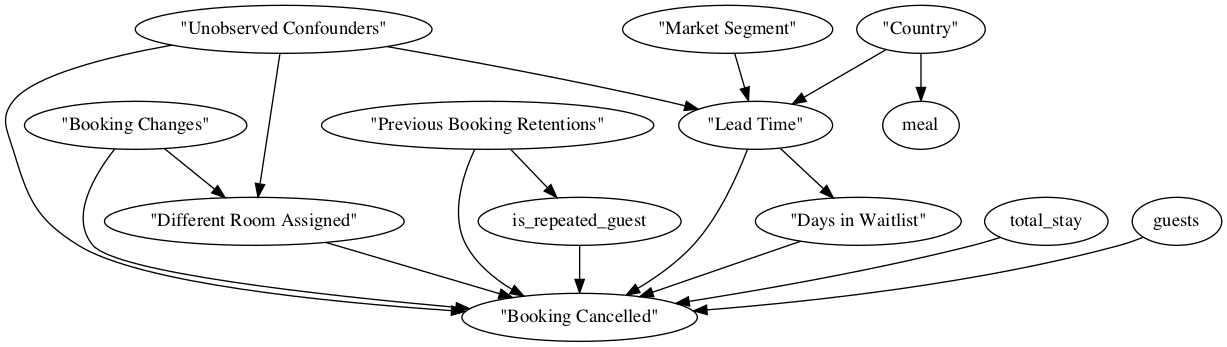

In [57]:
model= dowhy.CausalModel(
        data = data,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

 ## 3.3 识别因果效应

In [58]:

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|previous_bookings_not_cance
d[different_room_assigned]                                                    

                                                                              
led,country,booking_changes,market_segment,days_in_waiting_list,guests,is_repe
                                                                              

                                      
ated_guest,meal,lead_time,total_stay))
                                      
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,previous_bookings_not_canceled,country,booking_changes,market_segment,days_in_waiting_list,guests,is_repeated_guest,meal,lead_time,total_stay,U) = P(is_canceled|different_room_as

# 3.4 估计因果效应

In [59]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|previous_bookings_not_cance
d[different_room_assigned]                                                    

                                                                              
led,country,booking_changes,market_segment,days_in_waiting_list,guests,is_repe
                                                                              

                                      
ated_guest,meal,lead_time,total_stay))
                                      
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,previous_bookings_not_canceled,country,booking_changes,market_segment,days_in_waiting_list,guests,is_repeated_guest,meal,lead_time

## 3.5 反驳结果

In [61]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)


/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

Refute: Add a Random Common Cause
Estimated effect:-0.3366373801376331
New effect:-0.3365605173873847



In [62]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (st

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (st

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yufang.li/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is n

Refute: Use a Placebo Treatment
Estimated effect:-0.3366373801376331
New effect:2.1694371162038112e-05
p value:0.5



In [ ]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)
